# Banking


In [112]:
#!pip install gitpython
import git
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score, hamming_loss, fbeta_score, auc, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

### Download data from github

In [113]:
def download_github_repository(repo_url, repository_name, destination_folder):
# the inputs include: repository location, repository name, and destination folder name.
    # check to see if there is afolder with the same name as repository there. if yes, ask if it should be replaced.
    if os.path.exists(repository_name):
        response = input(f"{repository_name} already exists in {destination_folder}. do you want to update its contents? (yes/no): ").strip().lower()
        if response == 'yes':
            try:
                shutil.rmtree(repository_name)  # Delete the existing folder and its contents
            except Exception as e:
                print(f"error deleting {repository_name} folder: {e}")
                return
        else:
            print(f"fine. i left {repository_name} alone.")
            return
    # clone repository to the destination folder
    try:
        git.Git(destination_folder).clone(repo_url)
        print(f"okay i just deleted the old file and downloaded {repository_name} again from github. it's in the {destination_folder} folder.")
    except git.exc.GitCommandError as e:
        print(f"i wasn't able to get {repository_name} from github: {e}")

In [60]:
# define the following variables
github_account = "joel-day"
repository_name = "banking"
file_location_within_repository = "bank_marketing.csv"
destination_folder = "/content"

In [61]:
# clone the github repository
repository_url = f"https://github.com/{github_account}/{repository_name}"
download_github_repository(repository_url, repository_name, destination_folder)
# load the data into a pandas df
bank_main_df = pd.read_csv(f'{destination_folder}/{repository_name}/{file_location_within_repository}', delimiter=';')
bank_main_df.columns = bank_main_df.columns.str.replace(' ', '_')
bank_main_df.head()

banking already exists in /content. do you want to update its contents? (yes/no): 
fine. i left banking alone.


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,NaN,5,may,198,1,-1,0,unknown,no


# EDA

In [62]:
print(bank_main_df.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')


## Numerical

In [63]:
bank_main_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,43872.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.924781,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.610835,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


<Axes: xlabel='age', ylabel='Count'>

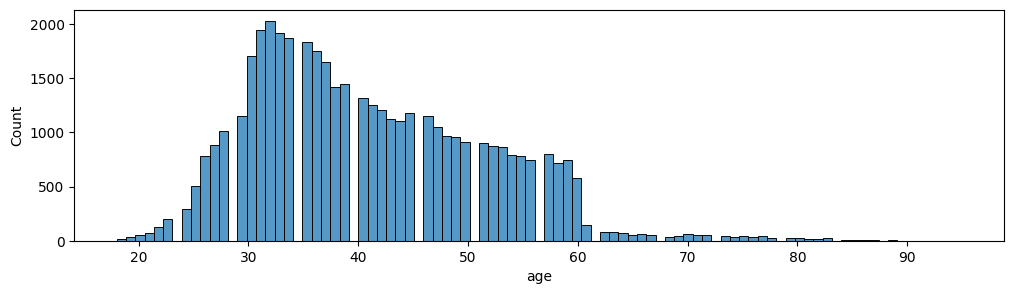

In [64]:
plt.figure(figsize=(12,3))
sns.histplot(data=bank_main_df,x='age')

## Categorical

In [65]:
bank_main_df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

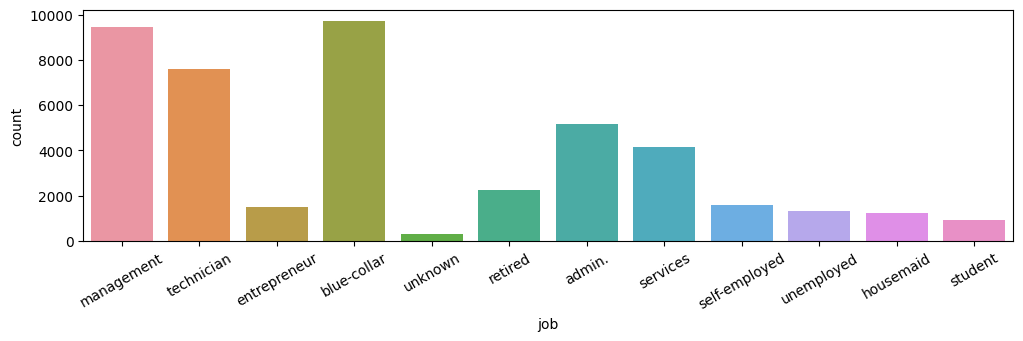

In [66]:
plt.figure(figsize=(12,3))
sns.countplot(data=bank_main_df, x='job')
plt.xticks(rotation=30);

# Feature Transformations

In [67]:
#creating a field that determines whether or not the customer was ever previously contacted
bank_main_df['prior_contact'] = [ 0 if bank_main_df['pdays'][i] == -1 else 1 for i in range(len(bank_main_df))]

#replacing the yes/no categorical values with 1/0 binary digits
bank_main_df['deposit'] = [0 if (bank_main_df['deposit'][i] == 'yes') else 1 for i in range(len(bank_main_df)) ]

#convert the "day" field to a categorical variable
bank_main_df['day'] = pd.Categorical(bank_main_df['day'])

#dropping pdays and previous, because the important information is captured in prior_contact
bank_main_df.drop(columns=['pdays','previous','job','marital','education','default','housing','loan','contact','month','duration'],inplace=True)

# One-Hot Encode Categorical

In [68]:
#(i.e. create dummy categorical variables) use drop_first=True to reduce the redundant column count
bank_main_df = pd.get_dummies(bank_main_df, drop_first=True)

# Imputing the missing values in "Age" variable
## Uses similar instances to estaimte what the age would be assuming a normal distrobution.

In [69]:
#note that only the "age" category has null values
pd.isnull(bank_main_df).sum()

age                 1339
balance                0
campaign               0
deposit                0
prior_contact          0
day_2                  0
day_3                  0
day_4                  0
day_5                  0
day_6                  0
day_7                  0
day_8                  0
day_9                  0
day_10                 0
day_11                 0
day_12                 0
day_13                 0
day_14                 0
day_15                 0
day_16                 0
day_17                 0
day_18                 0
day_19                 0
day_20                 0
day_21                 0
day_22                 0
day_23                 0
day_24                 0
day_25                 0
day_26                 0
day_27                 0
day_28                 0
day_29                 0
day_30                 0
day_31                 0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
dtype: int64

In [70]:
# Use multivariate imputer that estimates and imputes null values based on all the others.
imp = IterativeImputer(max_iter=10, verbose=0) # values passed are defaults, but added them because they seem important... play around
imp.fit(bank_main_df)
imputed_df = imp.transform(bank_main_df)
imputed_df = pd.DataFrame(imputed_df, columns=bank_main_df.columns)

In [73]:
X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## RF Most important features

## Create RF Classifier

In [80]:
clf = RandomForestClassifier()
# fit the classifier to the training set
clf.fit(X_train, y_train)
# predict on the test set
y_pred = clf.predict(X_test)
acc_ = accuracy_score(y_test, y_pred)
print(acc_)

0.8805662046593925


## Plot most importaint features

In [109]:
def feature_importance(model, original_x):
  # get feature importances and corresponding feature names
  importances = model.feature_importances_
  feature_names = original_x.columns

  # create a dictionary of feature names and importances then sort and extract
  feature_importance_dict = dict(zip(feature_names, importances))
  sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
  sorted_feature_names = list(sorted_feature_importance.keys())
  sorted_importances = list(sorted_feature_importance.values())

  # create the barplot
  plt.figure(figsize=(10, 6))
  ax = sns.barplot(y=sorted_feature_names, x=sorted_importances, orient='h')

  # calculate the total importance
  total_importance = sum(sorted_importances)
  # add percentages to the end of each bar
  for i, importance in enumerate(sorted_importances):
      percentage = (importance / total_importance) * 100
      ax.text(importance + 0.01, i, f'{percentage:.2f}%', va='center')

  # calculate top 5 leaderboard
  top_features = sorted_feature_names[:10]
  top_leaderboard = "\n".join([f"{i+1}. {feature}" for i, feature in enumerate(top_features)])

  # add top leaderboard text to the bottom right
  plt.text(0.9, 0.1, top_leaderboard, transform=ax.transAxes, fontsize=10, ha='right')

  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importances')
  plt.show()


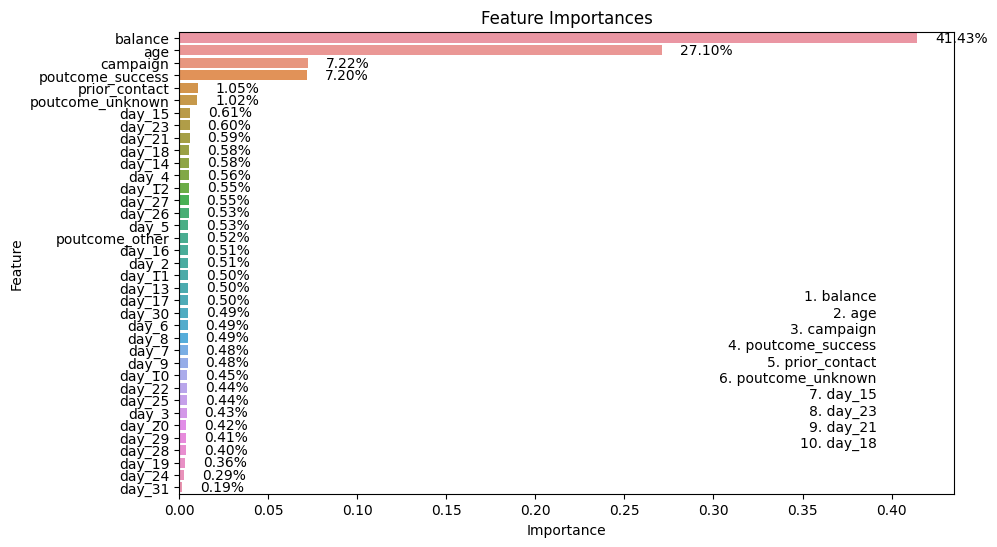

In [110]:
feature_importance(clf, X)

# Model building

In [126]:
classifiers = [
    KNeighborsClassifier(3), # works
    DecisionTreeClassifier(), # works
    RandomForestClassifier(), # works
    AdaBoostClassifier(), # works
    GradientBoostingClassifier(), # works
    GaussianNB(), # works
    BernoulliNB(), # works
    MLPClassifier(), # works
    #MLPClassifier(hidden_layer_sizes=[100, 100]), # works
    LinearDiscriminantAnalysis(), # works
    LogisticRegression(), # works
    QuadraticDiscriminantAnalysis(), # works
]
log_cols=["Classifier", "Accuracy", "F1_Score", "ROC"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
  name = clf.__class__.__name__
  clf.fit(X_train, y_train)
  train_predictions = clf.predict(X_test)

  acc_ = accuracy_score(y_test, train_predictions)
  acc = acc_.round(3)
  #print("Accuracy: {:.4%}".format(acc))

  fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
  fbeta = fbeta_.round(3)
  #print("F1 Score: {}".format(fbeta))

  roc_ = roc_auc_score(y_test, train_predictions)
  roc = roc_.round(3)
  #print("AUC (ROC) Score: {}".format(roc))

  log_entry = pd.DataFrame([[name, acc*100, fbeta, roc]], columns=log_cols)
  log = pd.concat([log,log_entry])

log = log.sort_values(by='F1_Score', ascending=False)
log

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Classifier,Accuracy,F1_Score,ROC
0,GradientBoostingClassifier,89.4,0.943,0.582
0,LinearDiscriminantAnalysis,89.4,0.943,0.584
0,LogisticRegression,89.4,0.943,0.583
0,AdaBoostClassifier,89.3,0.942,0.576
0,MLPClassifier,89.3,0.942,0.571
0,BernoulliNB,88.6,0.938,0.595
0,RandomForestClassifier,87.9,0.934,0.572
0,KNeighborsClassifier,87.0,0.929,0.574
0,DecisionTreeClassifier,82.2,0.899,0.572
0,QuadraticDiscriminantAnalysis,79.8,0.882,0.614


# Save all score as a png

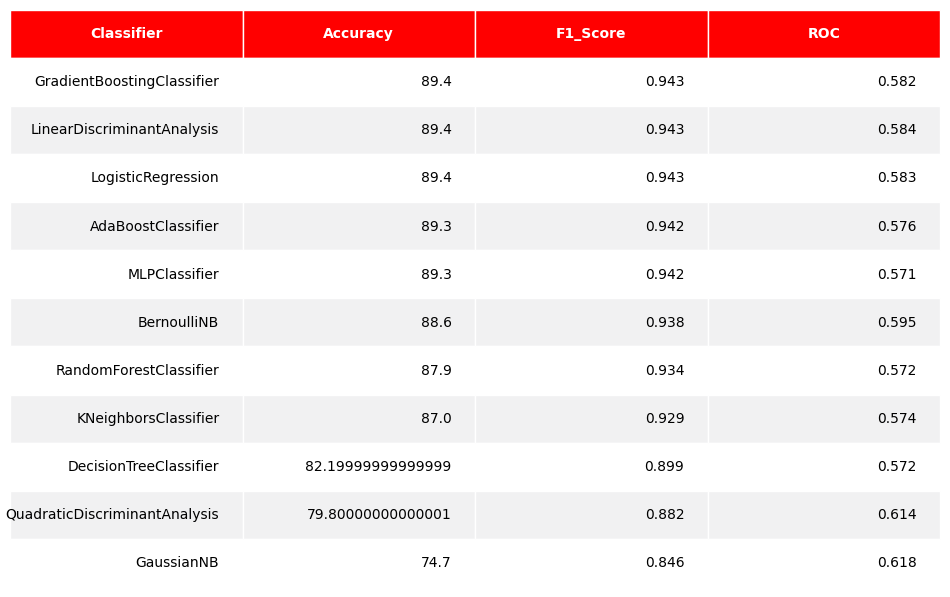

In [127]:
# Save DF as PNG
import numpy as np
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='red', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("/content/performance_table.png")

<Axes: ylabel='Classifier'>

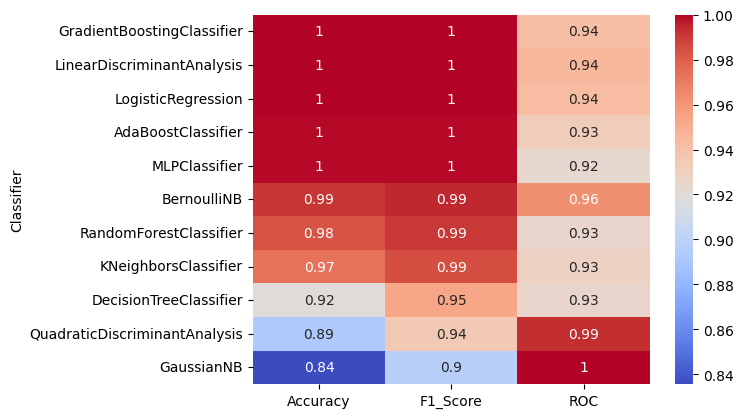

In [129]:
log1 = log.set_index('Classifier')
norm1_df = log1 / log1.max(0)
sns.heatmap(norm1_df.astype('float'),cmap='coolwarm',annot=True)

In [ ]:
a